In [1]:
import pickle
import matplotlib.pyplot as plt
from search_boxes import SearchResult
from typing import List, Dict
import numpy as np
import MDAnalysis as mda
#exp_dir = "tmp/exp_opt_1D_avg"
exp_dir = "tmp/exp_experiment_angular_scale_3nm_cutoff_5"
#exp_dir = "tmp/exp_ch3cn_rotate_angular_scale_3nm_cutoff_5"

with open(f"{exp_dir}/results.pkl", "rb") as f:
    results: List[SearchResult] = pickle.load(f)

/opt/mamba/envs/arpdf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/mamba/envs/arpdf/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
similarity_values = []
modified_atoms = []
for result in results:
    similarity_values.append(result.similarity)
    modified_atoms.append(result.modified_atoms)

In [3]:
print(similarity_values[0])
print(modified_atoms[0])

0.6200741769389131
[1]


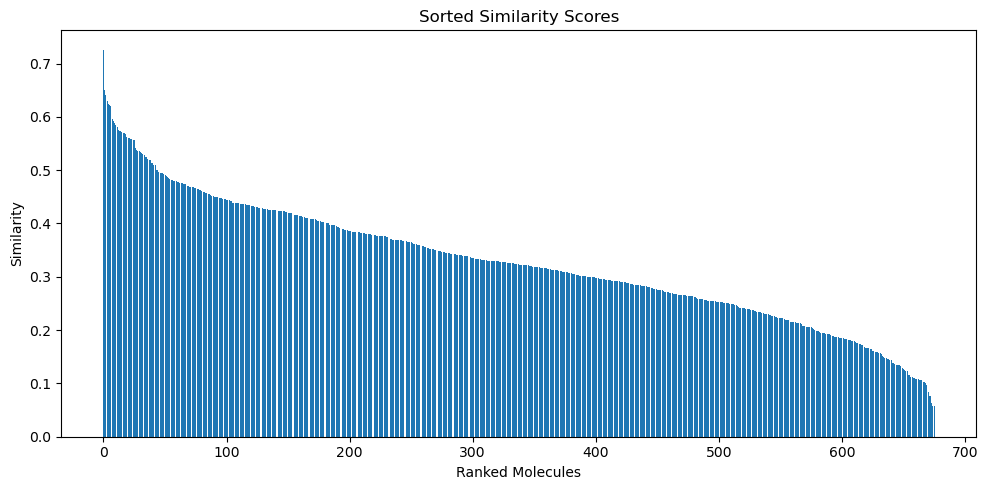

In [4]:
sorted_values = sorted(similarity_values, reverse=True)

plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_values)), sorted_values)
plt.xlabel("Ranked Molecules")
plt.ylabel("Similarity")
plt.title("Sorted Similarity Scores")
plt.tight_layout()
#plt.savefig("tmp/exp/sorted_similarity_barplot.png")
plt.show()

In [5]:
print(sorted_values[0])

0.7259795052108143


In [8]:
pairs = list(zip(similarity_values, modified_atoms))

# 排序取 top 10
top_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)[:20]

# 拆分为两个列表
top_similarities = [x[0] for x in top_pairs]
top_atoms = [x[1] for x in top_pairs]

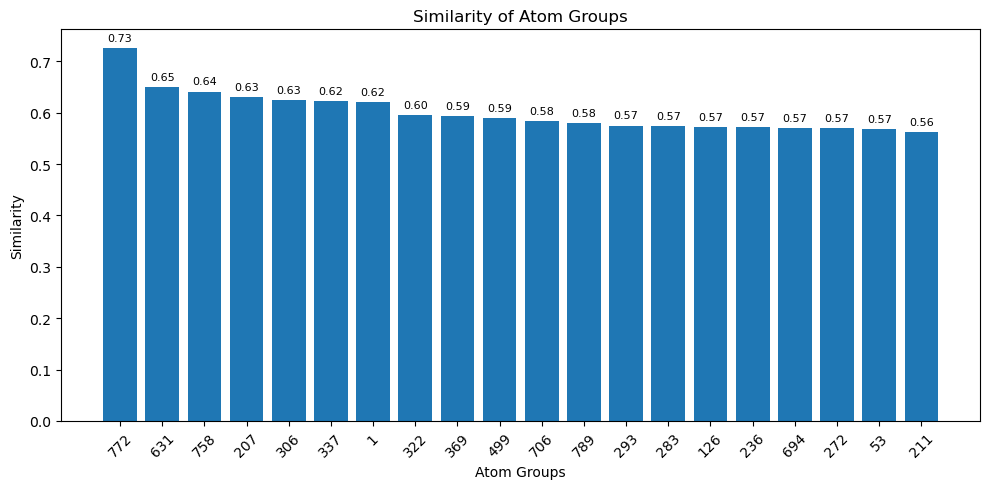

In [9]:
labels = ['-'.join(map(str, group)) for group in top_atoms]

# 画图
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(top_similarities)), top_similarities, tick_label=labels)
plt.xlabel("Atom Groups")
plt.ylabel("Similarity")
plt.title("Similarity of Atom Groups")
plt.xticks(rotation=45)  # x轴文字旋转，防止重叠

# 添加数值标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,  # 上方略微留白
             f"{top_similarities[i]:.2f}",  # 保留两位小数
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

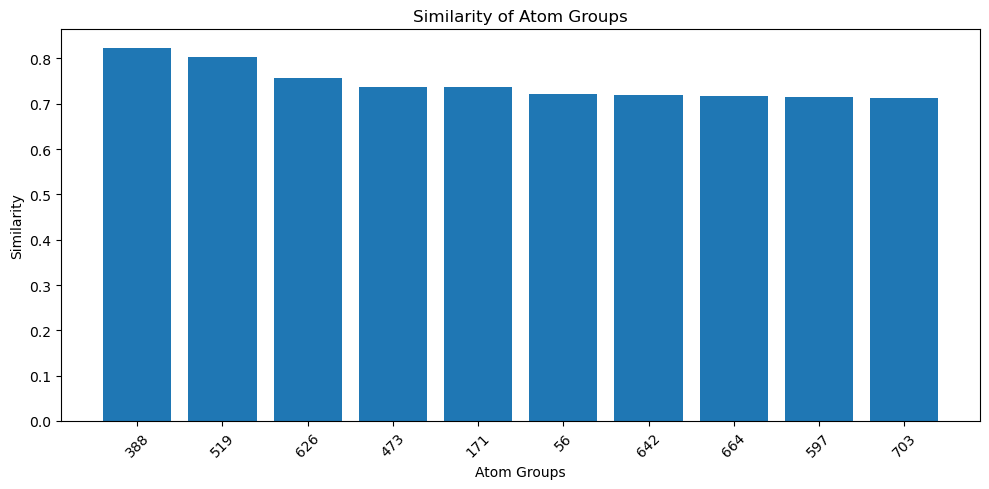

In [8]:
labels = ['-'.join(map(str, group)) for group in top_atoms]

# 画图
plt.figure(figsize=(10, 5))
plt.bar(range(len(top_similarities)), top_similarities, tick_label=labels)
plt.xlabel("Atom Groups")
plt.ylabel("Similarity")
plt.title("Similarity of Atom Groups")
plt.xticks(rotation=45)  # x轴文字旋转，防止重叠
plt.tight_layout()
plt.show()

In [10]:
import os
from utils import calculate_rmsd, load_structure_data, copy_atom_group, select_nbr_mols, generate_grids
from utils.analyze_structure import select_ccl4_molecules, analyze_ccl4_structure, rotate_ccl4_molecules, select_nearest_ccl4_molecules
from ARPDF import compare_ARPDF
from search_boxes import save_ccl4_result
import json
from dataclasses import asdict

In [50]:
# 设置参考结构目录
reference_dir = "data/CCl4"
output_dir = os.path.join(exp_dir, "post_analysis")

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# 加载参考结构
u1_ref, u2_ref, modified_atoms_ref, polar_axis_ref = load_structure_data(reference_dir)
ARPDF_ref = np.load(os.path.join(exp_dir, "ARPDF_ref.npy"))
with open(os.path.join(exp_dir, "metadata.json"), "r") as f:
    metadata = json.load(f)
xy_range = metadata["search_info"]["parameters"]["grids_range"]
N, M = metadata["search_info"]["parameters"]["grids_shape"]
X, Y = generate_grids(xy_range, N, M)


In [51]:
def get_ccl4_universe(universe, ccl4_mols):
    """
    Create a new universe containing only the selected CCl4 molecules
    """
    selected_atoms = universe.atoms[ccl4_mols]
    new_universe = mda.Merge(selected_atoms)
    new_universe.dimensions = universe.dimensions
    return new_universe


In [52]:
# Select the two CCl4 molecules by modified universe
ccl4_mols_ref = select_ccl4_molecules(u2_ref, 519)
# analyze the original structure of the selected CCl4 molecules
ccl4_universe_ref = get_ccl4_universe(u1_ref, ccl4_mols_ref)
#u1_ref = mda.Universe("data/CCl4/CCl4_5nm_clean.gro")
ref_res = analyze_ccl4_structure(
    u2_ref, 519, selected_indices=ccl4_mols_ref
)
print(ref_res)

# rotate and save the reference structure
nbr_indices = select_nbr_mols(u2_ref, modified_atoms_ref, nbr_distance=5.0)
nbr_group = rotate_ccl4_molecules(u2_ref, ccl4_mols_ref, nbr_indices, polar_axis_ref)
nbr_group.write(os.path.join(output_dir, 'ref_nbr.gro'))

StructureAnalysisResult(dist_C_A_CL_A=4.01125705099132, dist_CL_A_CL_B=2.5467437263973456, dist_C_B_CL_B=2.2976081469040177, dist_C_A_C_B=8.343410008965357, theta_CL_A_CL_B=32.606152640005995, umbrella_angle=2.8674367598856723)


In [53]:
# 计算每个搜索结果的RMSD
rmsd_values: List[float] = []
for i, result in enumerate(results):
    # 获取搜索结果结构
    u2_search = result.modified_universe
    u1_ref = mda.Universe("data/CCl4/CCl4_5nm_clean.gro")
    # 获取搜索结果的CCl4分子
    ccl4_mols_search = select_ccl4_molecules(u2_search, result.molecule)
    ccl4_universe_search = get_ccl4_universe(u1_ref, ccl4_mols_search)

    # 使用select_ccl4_molecules生成selection
    selection = [0, 1, 5, 6]

    # 计算RMSD
    rmsd = calculate_rmsd(ccl4_universe_search, ccl4_universe_ref, selection=selection) # TODO: 需要修改
    rmsd_values.append(rmsd)
    print(f"Result {i+1} RMSD: {rmsd:.3f} Å, similarity: {result.similarity:.3f}")

Result 1 RMSD: 0.980 Å, similarity: 0.415
Result 2 RMSD: 0.472 Å, similarity: 0.645
Result 3 RMSD: 0.728 Å, similarity: 0.450
Result 4 RMSD: 0.646 Å, similarity: 0.540
Result 5 RMSD: 0.328 Å, similarity: 0.476
Result 6 RMSD: 0.503 Å, similarity: 0.756
Result 7 RMSD: 1.085 Å, similarity: 0.348
Result 8 RMSD: 0.509 Å, similarity: 0.449
Result 9 RMSD: 0.669 Å, similarity: 0.441
Result 10 RMSD: 0.220 Å, similarity: 0.540
Result 11 RMSD: 0.917 Å, similarity: 0.410
Result 12 RMSD: 0.871 Å, similarity: 0.445
Result 13 RMSD: 0.635 Å, similarity: 0.516
Result 14 RMSD: 0.304 Å, similarity: 0.539
Result 15 RMSD: 0.156 Å, similarity: 0.589
Result 16 RMSD: 0.490 Å, similarity: 0.390
Result 17 RMSD: 0.783 Å, similarity: 0.500
Result 18 RMSD: 0.897 Å, similarity: 0.406
Result 19 RMSD: 0.539 Å, similarity: 0.542
Result 20 RMSD: 0.766 Å, similarity: 0.457
Result 21 RMSD: 0.664 Å, similarity: 0.354
Result 22 RMSD: 0.752 Å, similarity: 0.404
Result 23 RMSD: 0.867 Å, similarity: 0.312
Result 24 RMSD: 0.88

In [54]:
# 计算每个搜索结果的RMSD
rmsd_values: List[float] = []
rmsd_ave: List[float] =[]
C_Cl: List[float] = []
Cl_Cl: List[float] = []
above: List[float] = []
umbrella_angle: List[float] = []
for i, result in enumerate(results):
    # 获取搜索结果结构
    u2_search = result.modified_universe

    # 获取多个ccl4组合
    ccl4_mols_search_list = select_nearest_ccl4_molecules(u2_search, result.molecule, n_neighbors=3)

    
    # 这次要算多个RMSD取最小
    rmsd_candidates = []

    for ccl4_mols_search in ccl4_mols_search_list:
        ccl4_universe_search = get_ccl4_universe(u1_ref, ccl4_mols_search)

        selection = [0, 1, 5, 6]  # 选定自己和邻居的C和Cl

        rmsd = calculate_rmsd(ccl4_universe_search, ccl4_universe_ref, selection=selection)
        rmsd_candidates.append(rmsd)
    
    ccl4_mols_search = select_ccl4_molecules(u2_search, result.molecule)

    analysis = analyze_ccl4_structure(
        u2_search, 
        result.modified_atoms[0], 
        selected_indices=ccl4_mols_search
    )


    
    #Cl_Cl.append(abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B))
    Cl_Cl.append(analysis.dist_CL_A_CL_B)
    C_Cl.append(analysis.dist_C_A_CL_A)
    above.append(abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B)+abs(analysis.dist_C_A_CL_A-ref_res.dist_C_A_CL_A+0.8))
    umbrella_angle.append(analysis.umbrella_angle-ref_res.umbrella_angle)

    # 取最小值
    min_rmsd = min(rmsd_candidates)

    # 取平均值
    ave_rmsd = sum(rmsd_candidates) / len(rmsd_candidates)
    rmsd_values.append(min_rmsd)
    rmsd_ave.append(ave_rmsd)
    print(f"Result {i+1} minimal RMSD: {min_rmsd:.3f} Å, similarity: {result.similarity:.3f}")


Result 1 minimal RMSD: 0.449 Å, similarity: 0.415
Result 2 minimal RMSD: 0.435 Å, similarity: 0.645
Result 3 minimal RMSD: 0.696 Å, similarity: 0.450


Result 4 minimal RMSD: 0.572 Å, similarity: 0.540
Result 5 minimal RMSD: 0.328 Å, similarity: 0.476
Result 6 minimal RMSD: 0.503 Å, similarity: 0.756
Result 7 minimal RMSD: 0.413 Å, similarity: 0.348
Result 8 minimal RMSD: 0.509 Å, similarity: 0.449
Result 9 minimal RMSD: 0.367 Å, similarity: 0.441
Result 10 minimal RMSD: 0.220 Å, similarity: 0.540
Result 11 minimal RMSD: 0.784 Å, similarity: 0.410
Result 12 minimal RMSD: 0.802 Å, similarity: 0.445
Result 13 minimal RMSD: 0.635 Å, similarity: 0.516
Result 14 minimal RMSD: 0.304 Å, similarity: 0.539
Result 15 minimal RMSD: 0.156 Å, similarity: 0.589
Result 16 minimal RMSD: 0.490 Å, similarity: 0.390
Result 17 minimal RMSD: 0.700 Å, similarity: 0.500
Result 18 minimal RMSD: 0.897 Å, similarity: 0.406
Result 19 minimal RMSD: 0.373 Å, similarity: 0.542
Result 20 minimal RMSD: 0.611 Å, similarity: 0.457
Result 21 minimal RMSD: 0.616 Å, similarity: 0.354
Result 22 minimal RMSD: 0.453 Å, similarity: 0.404
Result 23 minimal RMSD: 0.801 Å, simi

In [28]:
# 计算每个搜索结果的RMSD
rmsd_values: List[float] = []
rmsd_ave: List[float] = []
C_Cl: List[float] = []
Cl_Cl: List[float] = []
above: List[float] = []
umbrella_angle: List[float] = []

for i, result in enumerate(results):
    # 获取搜索结果结构
    u2_search = result.modified_universe

    # 获取多个ccl4组合
    ccl4_mols_search_list = select_nearest_ccl4_molecules(u2_search, result.molecule, n_neighbors=3)

    # 这次要记录最小RMSD对应的分子组
    #min_rmsd = float('inf')
    #best_ccl4_mols = None
    #rmsd_candidates = []
    min_Cl_Cl = float('inf')
    min_C_Cl= float('inf')

    for ccl4_mols_search in ccl4_mols_search_list:
        ccl4_universe_search = get_ccl4_universe(u1_ref, ccl4_mols_search)

        selection = [0, 1, 5, 6]  # 选定自己和邻居的C和Cl

        analysis = analyze_ccl4_structure(
            u2_search, 
            result.modified_atoms[0], 
            selected_indices=ccl4_mols_search  
        )
        
        if abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B) < min_Cl_Cl:
            min_Cl_Cl = abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B)

        if abs(analysis.dist_C_A_C_B-ref_res.dist_C_A_C_B) < min_C_Cl:
            min_Cl_Cl = abs(analysis.dist_C_A_C_B-ref_res.dist_C_A_C_B)


    #Cl_Cl.append(abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B))
    Cl_Cl.append(min_Cl_Cl)
    C_Cl.append(min_C_Cl)
    #above.append(abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B)+abs(analysis.dist_C_A_CL_A-ref_res.dist_C_A_CL_A+0.8))
    #umbrella_angle.append(analysis.umbrella_angle-ref_res.umbrella_angle)
    
    # 取平均值
    #ave_rmsd = sum(rmsd_candidates) / len(rmsd_candidates)
    #rmsd_values.append(min_rmsd)
    #rmsd_ave.append(ave_rmsd)
    #print(f"Result {i+1} minimal RMSD: {min_rmsd:.3f} Å, similarity: {result.similarity:.3f}")

拟合公式: y = -0.1190 * x + 2.6489
Pearson相关系数 r = -0.0335, p-value = 6.1641e-02


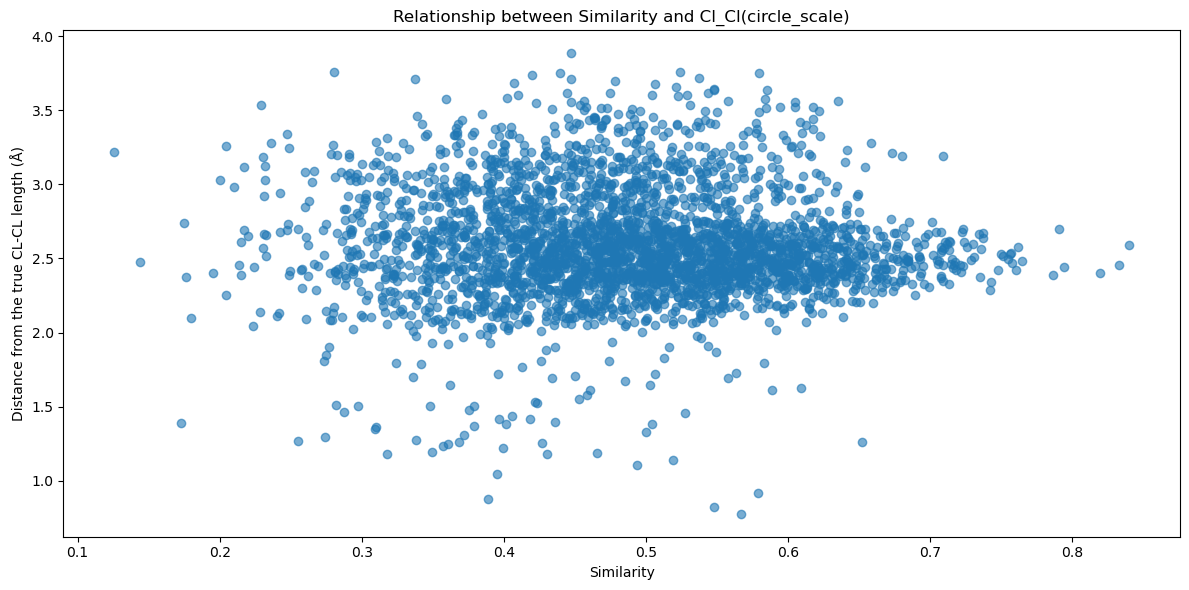

In [55]:
# 将Cl_Cl值与相似度对比
from scipy.stats import pearsonr 
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values, Cl_Cl, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('Distance from the true CL-CL length (Å)')
plt.title('Relationship between Similarity and Cl_Cl(circle_scale)')

# 添加趋势线
z = np.polyfit(similarity_values, Cl_Cl, 1)
p = np.poly1d(z)
#plt.plot(similarity_values, p(similarity_values), "r--", alpha=0.8)

# 打印拟合参数
slope = z[0]
intercept = z[1]
print(f"拟合公式: y = {slope:.4f} * x + {intercept:.4f}")

# 计算相关系数
corr_coef, p_value = pearsonr(similarity_values, Cl_Cl)
print(f"Pearson相关系数 r = {corr_coef:.4f}, p-value = {p_value:.4e}")

# 在图上标出拟合公式
#fit_text = f"y = {slope:.4f}x + {intercept:.4f}\nr = {corr_coef:.4f}"
#plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
#         fontsize=12, verticalalignment='top', color='red')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'similarity_vs_Cl_Cl.png'))
plt.show()

拟合公式: y = -0.0329 * x + 3.4188
Pearson相关系数 r = -0.0135, p-value = 4.5283e-01


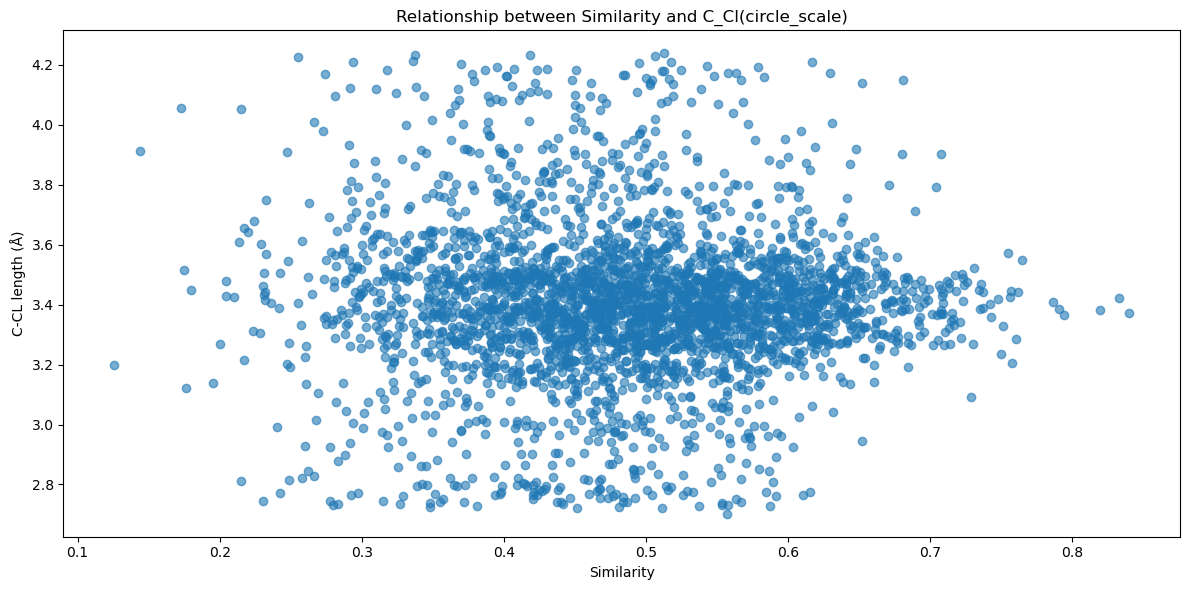

In [56]:
# 将C_Cl值与相似度对比
from scipy.stats import pearsonr 
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values, C_Cl, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('C-CL length (Å)')
plt.title('Relationship between Similarity and C_Cl(circle_scale)')

# 添加趋势线
z = np.polyfit(similarity_values, C_Cl, 1)
p = np.poly1d(z)
#plt.plot(similarity_values, p(similarity_values), "r--", alpha=0.8)

# 打印拟合参数
slope = z[0]
intercept = z[1]
print(f"拟合公式: y = {slope:.4f} * x + {intercept:.4f}")

# 计算相关系数
corr_coef, p_value = pearsonr(similarity_values, C_Cl)
print(f"Pearson相关系数 r = {corr_coef:.4f}, p-value = {p_value:.4e}")

# 在图上标出拟合公式
#fit_text = f"y = {slope:.4f}x + {intercept:.4f}\nr = {corr_coef:.4f}"
#plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
#         fontsize=12, verticalalignment='top', color='red')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'similarity_vs_C_Cl.png'))
plt.show()

In [18]:
print(len(similarity_values))
print(len(Cl_Cl))

676
676


拟合公式: y = -0.5067 * x + 0.7486
Pearson相关系数 r = -0.2972, p-value = 1.6269e-64


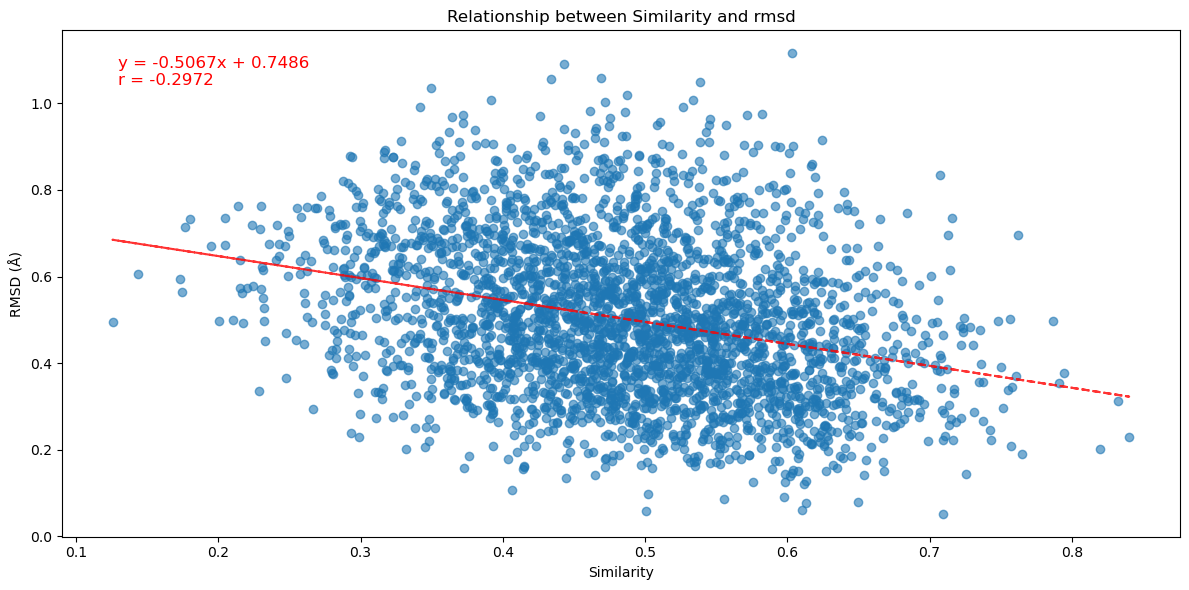

In [57]:
# 将rmsd值与相似度对比
from scipy.stats import pearsonr 
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values, rmsd_values, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('RMSD (Å)')
plt.title('Relationship between Similarity and rmsd')

# 添加趋势线
z = np.polyfit(similarity_values, rmsd_values, 1)
p = np.poly1d(z)
plt.plot(similarity_values, p(similarity_values), "r--", alpha=0.8)

# 打印拟合参数
slope = z[0]
intercept = z[1]
print(f"拟合公式: y = {slope:.4f} * x + {intercept:.4f}")

# 计算相关系数
corr_coef, p_value = pearsonr(similarity_values, rmsd_values)
print(f"Pearson相关系数 r = {corr_coef:.4f}, p-value = {p_value:.4e}")

# 在图上标出拟合公式
fit_text = f"y = {slope:.4f}x + {intercept:.4f}\nr = {corr_coef:.4f}"
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', color='red')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'similarity_vs_Cl-Cl.png'))
plt.show()

In [20]:
# Filter structures with similarity > 0.8 and RMSD > 1.0
filtered_structures = []
similarity_values_final: List[float] = []
C_Cl: List[float] = []
Cl_Cl: List[float] = []
umbrella_angle: List[float] = []
for i, (result, rmsd) in enumerate(zip(results, rmsd_values)):
    similarity = result.similarity
    if (rmsd > 0.4 and similarity > 0.7):
        # Get the search result structure
        u2_search = result.modified_universe
        # ARPDF_search[ARPDF_search > 0] = 0
        fig = compare_ARPDF(result.ARPDF, ARPDF_ref, grids_XY=(X, Y), cos_sim=similarity, show_range=8.0)
        fig.savefig(os.path.join(output_dir, f'filtered_structure_{i}_low.png'))
        ccl4_mols_search = select_ccl4_molecules(u2_search, result.modified_atoms[0])
        
        # Analyze the structure
        analysis = analyze_ccl4_structure(
            u2_search,
            result.modified_atoms[0],
            selected_indices=ccl4_mols_search
        )
        



        # Save structure information
        filtered_structures.append({
            'index': i,
            'similarity': float(similarity),
            'rmsd': float(rmsd),
            'analysis': asdict(analysis),
            'structure_path': os.path.join(output_dir, f'filtered_structure_{i}_low.gro').replace("\\", "/")
        })
        
        # Save the structure file
        save_ccl4_result(result, os.path.join(output_dir, f'filtered_structure_{i}_low.gro'), nbr_distance=5.0)

# Save filtered results to JSON
if filtered_structures:
    with open(os.path.join(output_dir, 'filtered_structures.json'), 'w') as f:
        json.dump(filtered_structures, f, indent=4)
    
    print(f"\nFound {len(filtered_structures)} structures with similarity > 0.8 and RMSD > 1.0")
    for structure in filtered_structures:
        print(f"Structure {structure['index']}: similarity={structure['similarity']:.3f}, RMSD={structure['rmsd']:.3f}Å")
else:
    print("\nNo structures found with similarity > 0.8 and RMSD > 1.0")


TypeError: compare_ARPDF() got an unexpected keyword argument 'cos_sim'

In [ ]:
# Filter structures based on geometric criteria
filtered_results = []
for i, result in enumerate(results):
    # Get the search result structure
    u2_search = result.modified_universe
    ccl4_mols_search = select_ccl4_molecules(u2_search, result.modified_atoms[0])
    # Analyze the structure
    analysis = analyze_ccl4_structure(
        u1_ref, 
        result.modified_atoms[0], 
        selected_indices=ccl4_mols_search
    )
    
    # Calculate differences from reference structure
    theta_diff = abs(analysis.theta_CL_A_CL_B - ref_res.theta_CL_A_CL_B)
    dist_C_A_C_B_diff = abs(analysis.dist_C_A_C_B - ref_res.dist_C_A_C_B)
    dist_CL_A_CL_B_diff = abs(analysis.dist_CL_A_CL_B - ref_res.dist_CL_A_CL_B)
    
    # Apply filtering criteria
    if (theta_diff < 10 and 
        dist_C_A_C_B_diff < 0.3 and 
        dist_CL_A_CL_B_diff < 0.3):
        filtered_results.append({
            'index': i,
            'similarity': result.similarity,
            'theta_diff': theta_diff,
            'dist_C_A_C_B_diff': dist_C_A_C_B_diff,
            'dist_CL_A_CL_B_diff': dist_CL_A_CL_B_diff,
            'analysis': analysis
        })

# Print filtered results
print(f"\nFound {len(filtered_results)} structures matching criteria:")
for res in filtered_results:
    print(f"Result {res['index']+1}:")
    print(f"  Similarity: {res['similarity']:.3f}")
    print(f"  Theta difference: {res['theta_diff']:.1f}°")
    print(f"  C_A_C_B distance difference: {res['dist_C_A_C_B_diff']:.3f} Å")
    print(f"  CL_A_CL_B distance difference: {res['dist_CL_A_CL_B_diff']:.3f} Å")

# Analyze similarity distribution of filtered structures
if filtered_results:
    filtered_similarities = [res['similarity'] for res in filtered_results]
    print("\nSimilarity statistics for filtered structures:")
    print(f"  Mean: {np.mean(filtered_similarities):.3f}")
    print(f"  Std: {np.std(filtered_similarities):.3f}")
    print(f"  Min: {np.min(filtered_similarities):.3f}")
    print(f"  Max: {np.max(filtered_similarities):.3f}")
    
    # Plot similarity distribution
    plt.figure(figsize=(8, 5))
    plt.hist(filtered_similarities, bins=10, alpha=0.7)
    plt.xlabel('Similarity')
    plt.ylabel('Count')
    plt.title('Similarity Distribution of Filtered Structures')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'filtered_similarity_dist.png'))
    plt.show()
else:
    print("\nNo structures matched the filtering criteria")
